# Import Libraries

In [1]:
import requests
import pandas as pd
import json
import geopandas as gpd
import re
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Denver

## Read in data

In [ ]:
# https://drive.google.com/file/d/1F5--R6Gz2B1w7HNlR55RzErPHojYvIWG/view?usp=drive_link
denver_gdf = gpd.read_file("../data/input/Traffic_Accidents_(Offenses).geojson")

In [8]:
denver_gdf

,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,...,TU2_PEDESTRIAN_ACTION,SERIOUSLY_INJURED,FATALITIES,FATALITY_MODE_1,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,geometry
0,211522192,2022187347,202218734754010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-04-15 23:00:00+00:00,2022-04-15 16:00:00+00:00,2022-04-15 18:19:00+00:00,1900 BLOCK CHESTNUT PL,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,POINT (-104.99965 39.75669)
1,211522193,2022344975,202234497554410,5441,0,TRAF - ACCIDENT,2022-07-07 20:50:00+00:00,2022-07-07 13:50:00+00:00,2022-07-07 13:52:00+00:00,E 49TH AVE / N HAVANA ST,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.86585 39.78675)
2,211522194,2022345001,202234500154410,5441,0,TRAF - ACCIDENT,2022-07-07 21:03:00+00:00,2022-07-07 14:03:00+00:00,2022-07-07 15:58:00+00:00,8000 E EASTMAN AVE,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.89562 39.65819)
3,211522195,2022345039,202234503954410,5441,0,TRAF - ACCIDENT,2022-07-07 21:22:00+00:00,2022-07-07 14:22:00+00:00,2022-07-07 15:16:00+00:00,1700 BLOCK N SHERIDAN BLVD,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-105.05276 39.74443)
4,211522196,2022318139,202231813954410,5441,0,TRAF - ACCIDENT,2022-06-23 21:28:00+00:00,2022-06-23 14:28:00+00:00,2022-06-23 14:28:00+00:00,S SANTA FE DR / W ALAMEDA AVE,...,OTHER,0.0,0.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.99714 39.71119)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252252,211774444,2022219486,202221948654010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-05-02 20:50:00+00:00,2022-05-02 13:50:00+00:00,2022-05-02 18:30:00+00:00,N COLORADO BLVD / E 23RD AVE,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,POINT (-104.94062 39.75104)
252253,211774445,2022174012,202217401254412,5441,2,TRAF - ACCIDENT - FATAL,2022-04-09 02:00:00+00:00,2022-04-08 19:00:00+00:00,2022-04-08 19:56:00+00:00,E COLFAX AVE / N RACE ST,...,OTHER,0.0,1.0,OTHER,OTHER,OTHER,OTHER,None,None,POINT (-104.96347 39.73999)
252254,211774446,20225001248,2022500124854410,5441,0,TRAF - ACCIDENT,2022-04-12 18:07:00+00:00,2022-04-12 11:07:00+00:00,2022-04-12 11:07:00+00:00,TEST,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,None
252255,211774447,2022195838,202219583854010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-04-20 16:30:00+00:00,2022-04-20 09:30:00+00:00,2022-04-20 10:39:00+00:00,1375 N WASHINGTON ST,...,UNDER INVESTIGATION,NaN,NaN,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,UNDER INVESTIGATION,None,None,POINT (-104.97906 39.73821)


## Data Cleaning

In [9]:
denver_gdf['occurrence_date'] = pd.to_datetime(denver_gdf['first_occurrence_date'])

In [10]:
# Create a new column for month and year
denver_gdf['month'] = denver_gdf['occurrence_date'].dt.month
denver_gdf['year'] = denver_gdf['occurrence_date'].dt.year

# Group by month and year, and count the occurrences
summary_table = denver_gdf.groupby(['month', 'year']).count()['object_id']

# Display the summary table
summary_table = summary_table.reset_index().rename(columns={'object_id':'total_incidents'})

In [11]:

denver_gdf['pedestrian_related'] = (denver_gdf['pedestrian_ind'] > 0) | (denver_gdf['HARMFUL_EVENT_SEQ_1'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE)) | (denver_gdf['HARMFUL_EVENT_SEQ_2'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE)) | (denver_gdf['HARMFUL_EVENT_SEQ_3'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE)) | (denver_gdf['top_traffic_accident_offense'].str.contains(r'PEDESTRIAN', flags=re.IGNORECASE))

In [12]:
denver_gdf[denver_gdf['pedestrian_related']==True]

,object_id,incident_id,offense_id,offense_code,offense_code_extension,top_traffic_accident_offense,first_occurrence_date,last_occurrence_date,reported_date,incident_address,...,FATALITY_MODE_2,SERIOUSLY_INJURED_MODE_1,SERIOUSLY_INJURED_MODE_2,POINT_X,POINT_Y,geometry,occurrence_date,month,year,pedestrian_related
44,211522236,2022143806,202214380654010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-03-24 01:24:00+00:00,2022-03-23 18:24:00+00:00,2022-03-23 19:12:00+00:00,W 32ND 33RD ALY / N WYANDOT ZUNI ALY,...,OTHER,OTHER,OTHER,None,None,POINT (-105.01496 39.76248),2022-03-24 01:24:00+00:00,3,2022,True
327,211522519,2021243588,202124358854410,5441,0,TRAF - ACCIDENT,2021-04-30 23:30:00+00:00,2021-04-30 16:30:00+00:00,2021-04-30 18:16:00+00:00,1100 BLOCK N ROSLYN ST,...,OTHER,OTHER,OTHER,None,None,POINT (-104.90089 39.73336),2021-04-30 23:30:00+00:00,4,2021,True
331,211522523,2021634102,202163410254010,5401,0,TRAF - ACCIDENT - HIT & RUN,2021-11-08 00:55:00+00:00,2021-11-07 17:55:00+00:00,2021-11-07 18:12:00+00:00,W 32ND AVE / N FEDERAL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.02524 39.76202),2021-11-08 00:55:00+00:00,11,2021,True
358,211522550,2021457801,202145780154410,5441,0,TRAF - ACCIDENT,2021-08-11 06:18:00+00:00,2021-08-10 23:18:00+00:00,2021-08-11 00:07:00+00:00,6TH TO LOWELL RAMP / N LOWELL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.03512 39.72576),2021-08-11 06:18:00+00:00,8,2021,True
378,211522570,2021656159,202165615954410,5441,0,TRAF - ACCIDENT,2021-11-19 16:14:00+00:00,2021-11-19 09:14:00+00:00,2021-11-19 09:31:00+00:00,E COLFAX AVE / N FRANKLIN ST,...,OTHER,OTHER,OTHER,None,None,POINT (-104.96846 39.74001),2021-11-19 16:14:00+00:00,11,2021,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252034,211774226,202251974,20225197454410,5441,0,TRAF - ACCIDENT,2022-02-01 01:45:00+00:00,2022-01-31 18:45:00+00:00,2022-01-31 18:45:00+00:00,W CROSS DR / S WADSWORTH BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.09130 39.61441),2022-02-01 01:45:00+00:00,2,2022,True
252129,211774321,202210115,20221011554410,5441,0,TRAF - ACCIDENT,2022-01-07 22:40:00+00:00,2022-01-07 15:40:00+00:00,2022-01-07 15:40:00+00:00,W 8TH AVE / N SANTA FE DR,...,OTHER,OTHER,OTHER,None,None,POINT (-104.99861 39.72890),2022-01-07 22:40:00+00:00,1,2022,True
252141,211774333,2022115009,202211500954010,5401,0,TRAF - ACCIDENT - HIT & RUN,2022-03-08 04:00:00+00:00,2022-03-07 21:00:00+00:00,2022-03-07 21:31:00+00:00,W 51ST AVE / N FEDERAL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.02519 39.78924),2022-03-08 04:00:00+00:00,3,2022,True
252227,211774419,202234612,20223461254412,5441,2,TRAF - ACCIDENT - FATAL,2022-01-22 05:50:00+00:00,2022-01-21 22:50:00+00:00,2022-01-21 23:19:00+00:00,1800 BLOCK S FEDERAL BLVD,...,OTHER,OTHER,OTHER,None,None,POINT (-105.02495 39.68317),2022-01-22 05:50:00+00:00,1,2022,True


In [88]:
denver_gdf[denver_gdf['pedestrian_related']==True]['ROAD_DESCRIPTION'].unique()

array(['AT INTERSECTION', 'NON INTERSECTION', 'INTERSECTION RELATED',
       'ALLEY RELATED', '  ', 'PARKING LOT', 'At Intersection',
       'Non-Intersection', 'Parking Lot', 'UNDER INVESTIGATION',
       'Mid-Block Crosswalk', 'Driveway Access Related', 'Alley Related',
       'Intersection Related', 'Roundabout', 'Ramp',
       'Express/Managed/HOV Lane', 'Share-Use Path or Trail',
       'Crossover-Related', 'Ramp Related', '', 'DRIVEWAY ACCESS RELATED',
       'HIGHWAY INTERCHANGE', 'ROUNDABOUT'], dtype=object)

In [90]:
denver_gdf['at_intersection'] = denver_gdf['ROAD_DESCRIPTION'].str.contains('AT INTERSECTION|INTERSECTION RELATED|At Intersection|Intersection Related', regex=True, flags=re.IGNORECASE)


In [13]:
summary_table1 = denver_gdf[denver_gdf['pedestrian_related']==True].groupby(['month', 'year']).count()['object_id']
summary_table1 = summary_table1.reset_index().rename(columns={'object_id':'total_pedestrian_incidents'})
summary_table1

,month,year,total_pedestrian_incidents
0,1,2013,68
1,1,2014,50
2,1,2015,57
3,1,2016,50
4,1,2017,41
...,...,...,...
134,12,2019,56
135,12,2020,25
136,12,2021,41
137,12,2022,42


In [92]:
summary_table2 = denver_gdf[(denver_gdf['pedestrian_related']==True) & (denver_gdf['at_intersection']==False)].groupby(['month', 'year']).count()['object_id']
summary_table2 = summary_table2.reset_index().rename(columns={'object_id':'total_pedestrian_nonintersection_incidents'})
summary_table2

,month,year,total_pedestrian_nonintersection_incidents
0,1,2013,27
1,1,2014,20
2,1,2015,23
3,1,2016,27
4,1,2017,17
...,...,...,...
134,12,2019,24
135,12,2020,8
136,12,2021,21
137,12,2022,21


In [15]:
denver_incidents_per_month = pd.merge(summary_table1, summary_table1, how='outer', left_on=['month','year'], right_on=['month','year'])
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents
0,1,2013,1855,68
1,1,2014,1941,50
2,1,2015,2015,57
3,1,2016,1961,50
4,1,2017,2103,41
...,...,...,...,...
134,12,2019,1934,56
135,12,2020,1371,25
136,12,2021,1407,41
137,12,2022,1437,42


In [93]:
denver_incidents_per_month = pd.merge(denver_incidents_per_month, summary_table2, how='outer', left_on=['month','year'], right_on=['month','year'])
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,percentage_pedestrian_incidents,D,P,total_pedestrian_nonintersection_incidents
0,0,1,2013,1855,68,0.036658,0,0,27
1,1,2,2013,1571,42,0.026735,0,0,13
2,2,3,2013,1681,41,0.024390,0,0,19
3,3,4,2013,1721,46,0.026729,0,0,21
4,4,5,2013,1717,45,0.026209,0,0,27
...,...,...,...,...,...,...,...,...,...
134,134,3,2024,1431,37,0.025856,1,14,16
135,135,4,2024,1422,46,0.032349,1,15,15
136,136,5,2024,1604,43,0.026808,1,16,18
137,137,6,2024,1590,47,0.029560,1,17,21


In [16]:
denver_incidents_per_month['percentage_pedestrian_incidents'] = denver_incidents_per_month['total_pedestrian_incidents'] / denver_incidents_per_month['total_incidents']
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents,percentage_pedestrian_incidents
0,1,2013,1855,68,0.036658
1,1,2014,1941,50,0.025760
2,1,2015,2015,57,0.028288
3,1,2016,1961,50,0.025497
4,1,2017,2103,41,0.019496
...,...,...,...,...,...
134,12,2019,1934,56,0.028956
135,12,2020,1371,25,0.018235
136,12,2021,1407,41,0.029140
137,12,2022,1437,42,0.029228


In [97]:
denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'] = denver_incidents_per_month['total_pedestrian_nonintersection_incidents'] / denver_incidents_per_month['total_incidents']
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,percentage_pedestrian_incidents,D,P,total_pedestrian_nonintersection_incidents,percentage_pedestrian_nonitersection_incidents,percentage_pedestrian_nonintersection_incidents
0,0,1,2013,1855,68,0.036658,0,0,27,0.014555,0.014555
1,1,2,2013,1571,42,0.026735,0,0,13,0.008275,0.008275
2,2,3,2013,1681,41,0.024390,0,0,19,0.011303,0.011303
3,3,4,2013,1721,46,0.026729,0,0,21,0.012202,0.012202
4,4,5,2013,1717,45,0.026209,0,0,27,0.015725,0.015725
...,...,...,...,...,...,...,...,...,...,...,...
134,134,3,2024,1431,37,0.025856,1,14,16,0.011181,0.011181
135,135,4,2024,1422,46,0.032349,1,15,15,0.010549,0.010549
136,136,5,2024,1604,43,0.026808,1,16,18,0.011222,0.011222
137,137,6,2024,1590,47,0.029560,1,17,21,0.013208,0.013208


In [17]:
denver_incidents_per_month = denver_incidents_per_month.sort_values(by=['year','month'])
denver_incidents_per_month

,month,year,total_incidents,total_pedestrian_incidents,percentage_pedestrian_incidents
0,1,2013,1855,68,0.036658
12,2,2013,1571,42,0.026735
24,3,2013,1681,41,0.024390
36,4,2013,1721,46,0.026729
48,5,2013,1717,45,0.026209
...,...,...,...,...,...
35,3,2024,1431,37,0.025856
47,4,2024,1422,46,0.032349
59,5,2024,1604,43,0.026808
71,6,2024,1590,47,0.029560


In [32]:
denver_incidents_per_month = denver_incidents_per_month.reset_index().drop(columns='index').reset_index().rename(columns={'index':'T'})
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,percentage_pedestrian_incidents
0,0,1,2013,1855,68,0.036658
1,1,2,2013,1571,42,0.026735
2,2,3,2013,1681,41,0.024390
3,3,4,2013,1721,46,0.026729
4,4,5,2013,1717,45,0.026209
...,...,...,...,...,...,...
134,134,3,2024,1431,37,0.025856
135,135,4,2024,1422,46,0.032349
136,136,5,2024,1604,43,0.026808
137,137,6,2024,1590,47,0.029560


In [34]:
denver_incidents_per_month['D'] = denver_incidents_per_month.apply(lambda row: 1 if (row['month'] > 1 and row['year'] == 2023) or (row['year'] > 2023) else 0, axis=1)
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,percentage_pedestrian_incidents,D
0,0,1,2013,1855,68,0.036658,0
1,1,2,2013,1571,42,0.026735,0
2,2,3,2013,1681,41,0.024390,0
3,3,4,2013,1721,46,0.026729,0
4,4,5,2013,1717,45,0.026209,0
...,...,...,...,...,...,...,...
134,134,3,2024,1431,37,0.025856,1
135,135,4,2024,1422,46,0.032349,1
136,136,5,2024,1604,43,0.026808,1
137,137,6,2024,1590,47,0.029560,1


In [35]:
denver_incidents_per_month['P'] = denver_incidents_per_month['D'].cumsum()
denver_incidents_per_month

,T,month,year,total_incidents,total_pedestrian_incidents,percentage_pedestrian_incidents,D,P
0,0,1,2013,1855,68,0.036658,0,0
1,1,2,2013,1571,42,0.026735,0,0
2,2,3,2013,1681,41,0.024390,0,0
3,3,4,2013,1721,46,0.026729,0,0
4,4,5,2013,1717,45,0.026209,0,0
...,...,...,...,...,...,...,...,...
134,134,3,2024,1431,37,0.025856,1,14
135,135,4,2024,1422,46,0.032349,1,15
136,136,5,2024,1604,43,0.026808,1,16
137,137,6,2024,1590,47,0.029560,1,17


## Modeling

### Pedestrian-Vehicle Crashes

In [40]:
def test_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4]. items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("Series is stationary")
    else:
        print("Series is not stationary")

In [20]:
test_stationarity(denver_incidents_per_month['percentage_pedestrian_incidents'])

ADF Statistic: -4.751663
p-value: 0.000067
Critical Values:
	1%: -3.480
	5%: -2.883
	10%: -2.578
Series is stationary


In [98]:
test_stationarity(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'])

ADF Statistic: -8.494388
p-value: 0.000000
Critical Values:
	1%: -3.479
	5%: -2.883
	10%: -2.578
Series is stationary


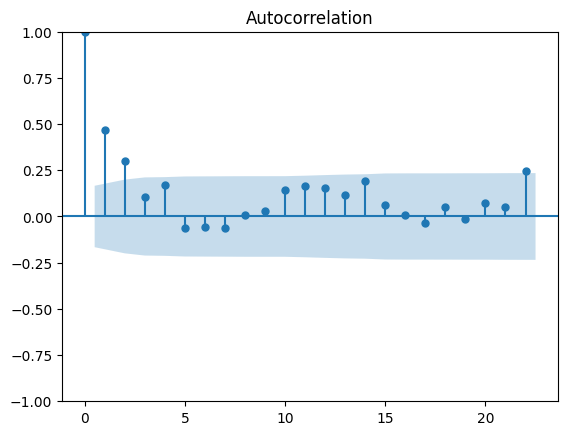

In [26]:
plot_acf(denver_incidents_per_month['percentage_pedestrian_incidents'])
plt.show()

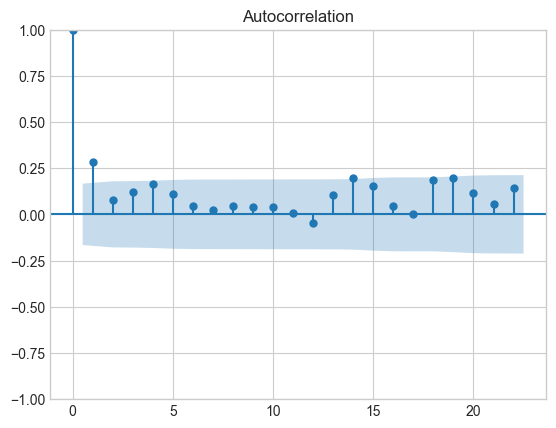

In [99]:
plot_acf(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'])
plt.show()

In [47]:
auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_incidents'], 
                      X=denver_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=5, max_q=5, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

auto_model_full.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-834.983, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1051.297, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-920.725, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1061.608, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1060.092, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1060.764, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1063.817, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1060.778, Time=0.09 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-974.856, Time=0.07 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-1053.346, Time=0.13 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1075.480, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-958.718, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1067.974, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1071.589, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  139
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 549.688
Date:                Thu, 01 Aug 2024   AIC                          -1085.375
Time:                        12:36:10   BIC                          -1064.834
Sample:                             0   HQIC                         -1077.028
                                - 139                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0241      0.002     15.361      0.000       0.021       0.027
T           -1.54e-05   2.12e-05     -0.725      0.468    -5.7e-05    2.62e-05
D             -0.0040      0.004     -1.088      0.277      -0.011       0.003
P              0.0008      0.000      2.293      0.022       0.000       0.002
ma.L1          0.5812      0.072      8.034      0.000       0.439       0.723
ma.L2          0.4795      0.069      6.946      0.000       0.344       0.615
sigma2      2.142e-05   3.08e-06      6.962      0.000    1.54e-05    2.75e-05
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):                 1.98
Prob(Q):                              0.29   Prob(JB):                         0.37
Heteroskedasticity (H):               1.48   Skew:                             0.23
Prob(H) (two-sided):                  0.19   Kurtosis:                         2.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

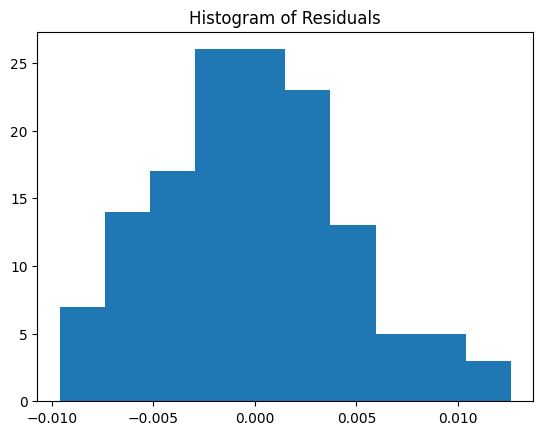

In [37]:
# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-563.165, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-912.761, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-670.936, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-925.732, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-924.301, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-925.141, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-928.832, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-927.067, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-769.811, Time=0.03 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-930.625, Time=0.10 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-918.546, Time=0.07 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-939.230, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-933.787, Time=0.02 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=-935.946, Time=0.03 sec
 ARIMA(2,0,4)(0,0,0)[0]          

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_38395/1734326494.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


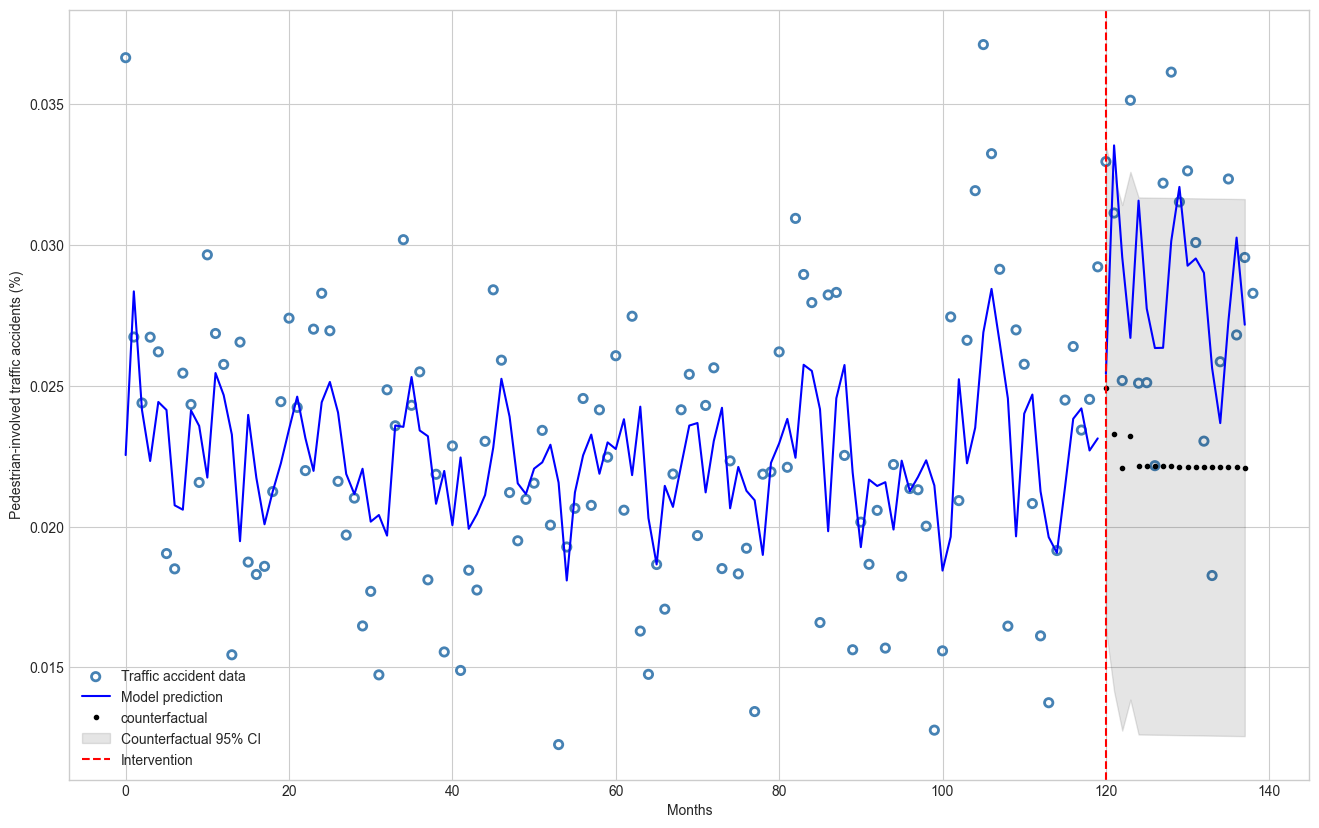

In [85]:
start = 120
end = len(denver_incidents_per_month)

arima_results = ARIMA(denver_incidents_per_month['percentage_pedestrian_incidents'], denver_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_incidents'][:start], exogenous=denver_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=5, max_q=5, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(denver_incidents_per_month['percentage_pedestrian_incidents'][:start], denver_incidents_per_month["T"][:start], order=auto_model_cf.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=denver_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(denver_incidents_per_month["T"], denver_incidents_per_month["percentage_pedestrian_incidents"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(denver_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(denver_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=denver_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Pedestrian-involved traffic accidents (%)")
plt.show()

### Non-Intersection Pedestrian-Vehicle Crashes

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1045.394, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1182.445, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1107.295, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1191.423, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1201.102, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-1205.830, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-1203.568, Time=0.04 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1202.522, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1196.161, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-1201.219, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=-1215.322, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=-1211.563, Time=0.07 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=-1216.065, Time=0.19 sec
 ARIMA(6,0,0)(0,0,0)[0] intercept   : AIC=-1214.355, Time=0.24 sec
 ARIMA(5,0,1)(0,0,0

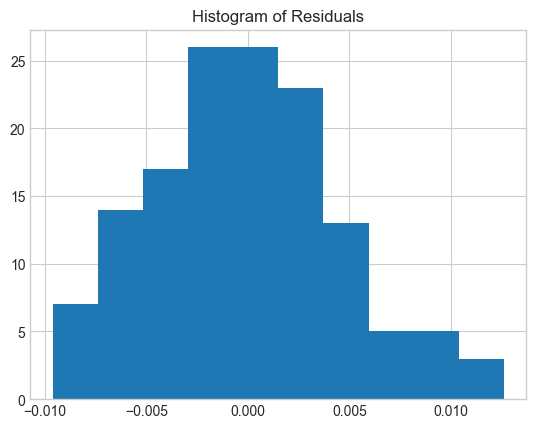

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-749.317, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1010.843, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-850.814, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1026.248, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-1041.170, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-1036.580, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.17 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-1047.681, Time=0.03 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-1049.515, Time=0.02 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=-1048.192, Time=0.03 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-1048.925, Time=0.04 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=-1052.677, Time=0.04 sec
 ARIMA(3,0,2)(0,0,0)[0]             : A

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_38395/3652603327.py:51: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


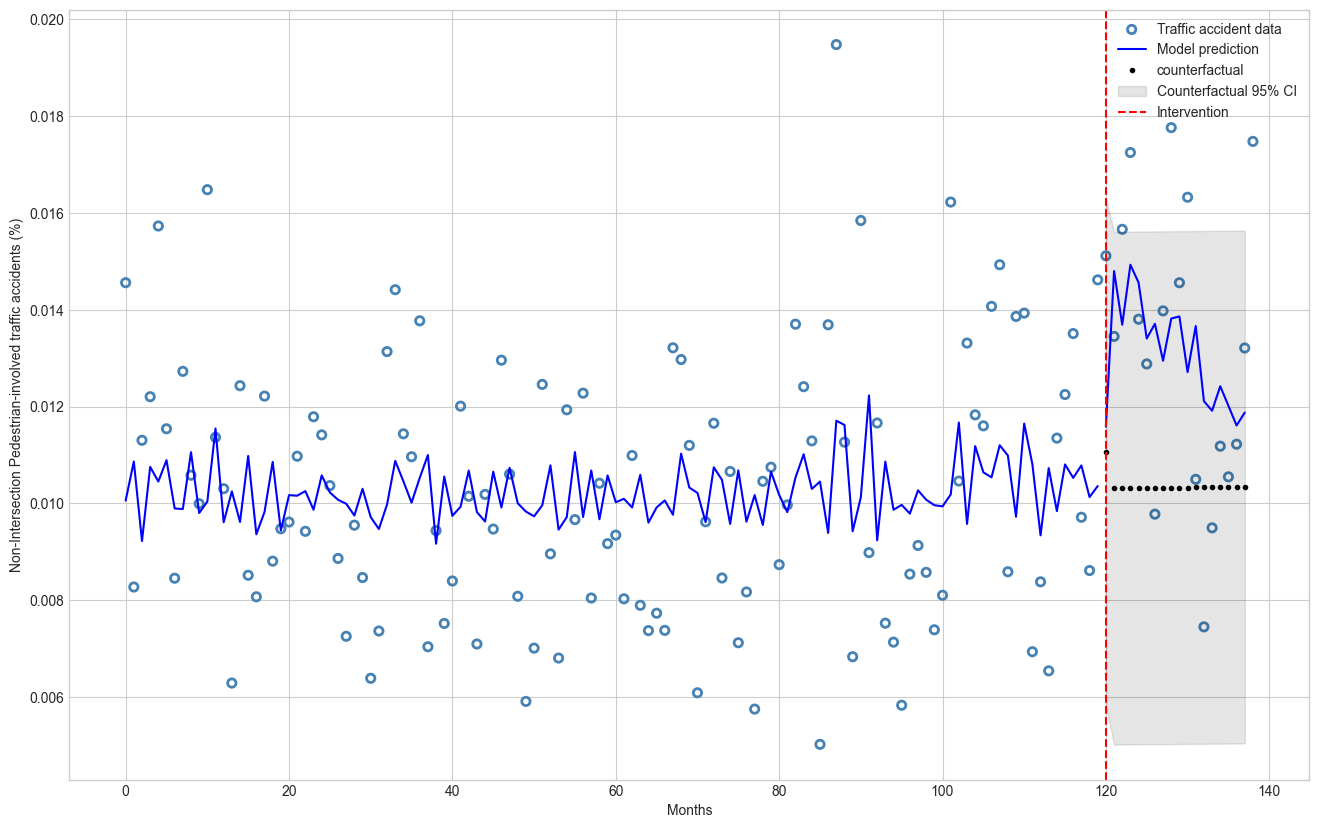

In [102]:
auto_model_full = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'], 
                      X=denver_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

print(auto_model_full.summary())

# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()
start = 120
end = len(denver_incidents_per_month)

arima_results = ARIMA(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'], denver_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'][:start], exogenous=denver_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=20, max_q=20, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(denver_incidents_per_month['percentage_pedestrian_nonintersection_incidents'][:start], denver_incidents_per_month["T"][:start], order=auto_model_cf.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=denver_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(denver_incidents_per_month["T"], denver_incidents_per_month["percentage_pedestrian_nonintersection_incidents"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(denver_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(denver_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(denver_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=denver_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Non-Intersection Pedestrian-involved traffic accidents (%)")
plt.show()

# Virginia Beach

## Read in data

In [4]:
# https://drive.google.com/file/d/1DBFAzfgXdHNaCiXlfn859P3PSde_LokI/view?usp=drive_link
virginia_df = pd.read_csv("../data/input/CrashData_test_6478750435646127290.csv")
virginia_df

,OBJECTID,Document Nbr,Crash Year,Crash Date,Crash Military Time,Crash Severity,K_People,A_People,B_People,C_People,...,VSP,Ownership,Planning District,MPO Name,RTE Name,RNS MP,Node,Node Offset (ft),x,y
0,1,163465085,2016,12/6/2016 5:00:00 AM,700,O,0,0,0,0,...,7,1. State Hwy Agency,Northern Virginia,NOVA,R-VA IS00095NB,158.85,NaN,NaN,-77.280787,38.653845
1,2,160725125,2016,1/26/2016 5:00:00 AM,1636,O,0,0,0,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,S-VA114NP WOODLAND RD,0.50,253154.0,318.32,-76.322790,37.027737
2,3,160465260,2016,2/13/2016 5:00:00 AM,1845,B,0,0,2,0,...,1,1. State Hwy Agency,Northern Neck,NaN,R-VA066SC00640NB,2.54,1149141.0,5.82,-76.362036,37.898547
3,4,161255113,2016,3/26/2016 4:00:00 AM,1,O,0,0,0,0,...,1,1. State Hwy Agency,Richmond Regional,RICH,R-VA042SC00782SB,1.19,NaN,NaN,-77.453780,37.695529
4,5,162005180,2016,7/18/2016 4:00:00 AM,732,O,0,0,0,0,...,6,1. State Hwy Agency,"Roanoke Valley-Alleghany, West Piedmont",NaN,R-VA US00220NB,48.61,328737.0,5.34,-79.942464,37.103654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040819,1040820,240455170,2024,2/10/2024 5:00:00 AM,1153,B,0,0,2,0,...,5,3. City or Town Hwy Agency,Hampton Roads,HAMP,R-VA SR00168NBBUS001,11.51,1094526.0,68.79,-76.240189,36.733799
1040820,1040821,240465044,2024,2/10/2024 5:00:00 AM,1755,O,0,0,0,0,...,5,1. State Hwy Agency,Hampton Roads,HAMP,R-VA IS00064WB RMP278.00A,0.14,NaN,NaN,-76.238467,36.904584
1040821,1040822,240835174,2024,3/22/2024 4:00:00 AM,1434,B,0,0,3,0,...,7,1. State Hwy Agency,Northern Virginia,NOVA,R-VA IS00395NB,6.25,NaN,NaN,-77.094333,38.835522
1040822,1040823,240925234,2024,3/31/2024 4:00:00 AM,1952,O,0,0,0,0,...,7,1. State Hwy Agency,Northern Virginia,NOVA,R-VA IS00495SB,6.71,NaN,NaN,-77.220283,38.850899


In [21]:
vb_df = virginia_df[virginia_df['Physical Juris Name'].str.contains('Virginia Beach', flags=re.IGNORECASE)]

In [22]:
vb_df

,OBJECTID,Document Nbr,Crash Year,Crash Date,Crash Military Time,Crash Severity,K_People,A_People,B_People,C_People,...,Planning District,MPO Name,RTE Name,RNS MP,Node,Node Offset (ft),x,y,Crash Datetime,crash_month
14,15,160575250,2016,2016-02-25 05:00:00,1827,B,0,0,1,0,...,Hampton Roads,HAMP,S-VA134NP GENERAL BOOTH BLVD,4.20,1041506.0,191.85,-76.006695,36.774809,2016-02-25 05:00:00,2
20,21,160105153,2016,2016-01-08 05:00:00,1743,O,0,0,0,0,...,Hampton Roads,HAMP,R-VA US00058WB,500.94,1262135.0,185.10,-76.129230,36.843566,2016-01-08 05:00:00,1
75,76,162305330,2016,2016-08-17 04:00:00,1635,B,0,0,1,0,...,Hampton Roads,HAMP,R-VA US00058EB,504.77,1091398.0,27.19,-76.063078,36.841365,2016-08-17 04:00:00,8
76,77,170340061,2016,2016-11-25 05:00:00,1820,O,0,0,0,0,...,Hampton Roads,HAMP,S-VA134NP WESLEYAN DR,2.01,1261844.0,22.11,-76.186426,36.872855,2016-11-25 05:00:00,11
124,125,161645081,2016,2016-06-10 04:00:00,942,B,0,0,1,1,...,Hampton Roads,HAMP,S-VA134PR BIRDNECK RD S,2.66,542025.0,97.65,-75.995777,36.844128,2016-06-10 04:00:00,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1040766,1040767,241645584,2024,2024-05-31 04:00:00,207,O,0,0,0,0,...,Hampton Roads,HAMP,S-VA134NP FERRELL PKWY,0.48,NaN,NaN,-76.131520,36.796350,2024-05-31 04:00:00,5
1040804,1040805,240345094,2024,2024-01-27 05:00:00,628,O,0,0,0,0,...,Hampton Roads,HAMP,S-VA134NP WESLEYAN DR,1.69,1087290.0,62.94,-76.181144,36.871365,2024-01-27 05:00:00,1
1040807,1040808,241105255,2024,2024-04-13 04:00:00,1743,O,0,0,0,0,...,Hampton Roads,HAMP,S-VA134NP LYNNHAVEN PKWY,4.81,1091355.0,114.59,-76.108215,36.794608,2024-04-13 04:00:00,4
1040810,1040811,241535011,2024,2024-05-28 04:00:00,2148,B,0,0,1,1,...,Hampton Roads,HAMP,S-VA134NP GENERAL BOOTH BLVD,3.35,541475.0,66.95,-75.999134,36.786029,2024-05-28 04:00:00,5


## Data Cleaning

In [23]:
vb_df['Crash Datetime'] = pd.to_datetime(vb_df['Crash Date'])

/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_47426/3869065145.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Crash Datetime'] = pd.to_datetime(df['Crash Date'])


In [24]:
vb_df['crash_month'] = vb_df['Crash Datetime'].dt.month

/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_47426/1833385694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['crash_month'] = df['Crash Datetime'].dt.month


In [25]:
vb_total_crashes_month_year = vb_df.groupby(['crash_month', 'Crash Year']).count()['OBJECTID']
vb_total_crashes_month_year = vb_total_crashes_month_year.reset_index().rename(columns={'OBJECTID':'total_crashes'})

In [26]:
vb_total_pedesrian_crashes_month_year = vb_df[vb_df['Pedestrian?']=='Yes'].groupby(['crash_month', 'Crash Year']).count()['OBJECTID']
vb_total_pedesrian_crashes_month_year = vb_total_pedesrian_crashes_month_year.reset_index().rename(columns={'OBJECTID':'total_pedestrian_crashes'})

In [27]:
vb_total_pedestrian_nonintersection_crashes_month_year = vb_df[(vb_df['Pedestrian?']=='Yes') & (vb_df['Intersection Type']=='1. Not at Intersection')].groupby(['crash_month', 'Crash Year']).count()['OBJECTID']
vb_total_pedestrian_nonintersection_crashes_month_year = vb_total_pedestrian_nonintersection_crashes_month_year.reset_index().rename(columns={'OBJECTID':'total_pedestrian_nonintersection_crashes'})

In [28]:
vb_incidents_per_month = pd.merge(vb_total_crashes_month_year, vb_total_pedesrian_crashes_month_year, how='outer', left_on=['crash_month','Crash Year'], right_on=['crash_month','Crash Year'])
vb_incidents_per_month = pd.merge(vb_incidents_per_month, vb_total_pedestrian_nonintersection_crashes_month_year, how='outer', left_on=['crash_month','Crash Year'], right_on=['crash_month','Crash Year'])
vb_incidents_per_month

,crash_month,Crash Year,total_crashes,total_pedestrian_crashes,total_pedestrian_nonintersection_crashes
0,1,2016,517,7.0,2.0
1,1,2017,493,7.0,3.0
2,1,2018,523,4.0,NaN
3,1,2019,452,1.0,1.0
4,1,2020,517,4.0,2.0
...,...,...,...,...,...
96,12,2019,555,7.0,3.0
97,12,2020,433,6.0,5.0
98,12,2021,491,4.0,1.0
99,12,2022,464,3.0,1.0


In [29]:
vb_incidents_per_month['percentage_pedestrian_crashes'] = vb_incidents_per_month['total_pedestrian_crashes'] / vb_incidents_per_month['total_crashes']

In [30]:
vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'] = vb_incidents_per_month['total_pedestrian_nonintersection_crashes'] / vb_incidents_per_month['total_crashes']

In [31]:
vb_incidents_per_month = vb_incidents_per_month.sort_values(by=['Crash Year','crash_month'])

In [32]:
vb_incidents_per_month = vb_incidents_per_month.reset_index().drop(columns='index').reset_index().rename(columns={'index':'T'})
vb_incidents_per_month['D'] = vb_incidents_per_month.apply(lambda row: 1 if (row['crash_month'] > 2 and row['Crash Year'] == 2021) or (row['Crash Year'] > 2021) else 0, axis=1)
vb_incidents_per_month['P'] = vb_incidents_per_month['D'].cumsum()

In [33]:
vb_incidents_per_month

,T,crash_month,Crash Year,total_crashes,total_pedestrian_crashes,total_pedestrian_nonintersection_crashes,percentage_pedestrian_crashes,percentage_pedestrian_nonintersection_crashes,D,P
0,0,1,2016,517,7.0,2.0,0.013540,0.003868,0,0
1,1,2,2016,569,10.0,4.0,0.017575,0.007030,0,0
2,2,3,2016,571,7.0,2.0,0.012259,0.003503,0,0
3,3,4,2016,704,9.0,2.0,0.012784,0.002841,0,0
4,4,5,2016,627,8.0,3.0,0.012759,0.004785,0,0
...,...,...,...,...,...,...,...,...,...,...
96,96,1,2024,362,7.0,3.0,0.019337,0.008287,1,35
97,97,2,2024,419,5.0,1.0,0.011933,0.002387,1,36
98,98,3,2024,439,9.0,6.0,0.020501,0.013667,1,37
99,99,4,2024,424,6.0,NaN,0.014151,NaN,1,38


In [44]:
vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'].fillna(0, inplace=True)
vb_incidents_per_month['percentage_pedestrian_crashes'].fillna(0, inplace=True)

## Modeling

### Non-Intersection Pedestrian-Vehicle Crashes

ADF Statistic: -11.347436
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582
Series is stationary
None


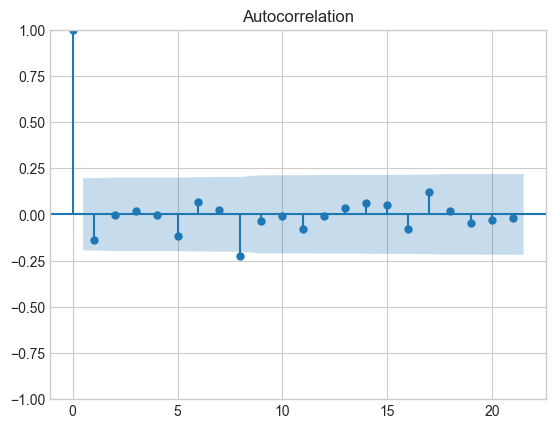

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-812.643, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-811.529, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-811.090, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-808.926, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-816.259, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-814.142, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-813.424, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-810.511, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.353 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  101
Model:                        SARIMAX   Log Likelihood                 413.130
Date:                Fri, 02 Aug 2024   AIC                           -816.259
Time:                        10:23:4

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


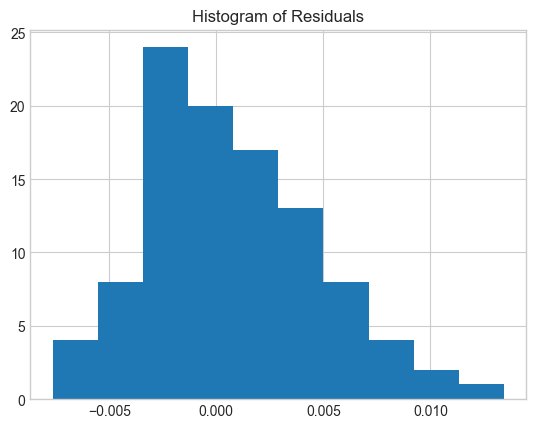

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-452.013, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-487.684, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-470.525, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-496.949, Time=0.01 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-506.625, Time=0.01 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-506.974, Time=0.03 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=-507.578, Time=0.02 sec
 ARIMA(6,0,0)(0,0,0)[0]             : AIC=inf, Time=0.10 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=-508.058, Time=0.13 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=-505.151, Time=0.04 sec
 ARIMA(6,0,1)(0,0,0)[0]             : AIC=-509.267, Time=0.11 sec
 ARIMA(7,0,1)(0,0,0)[0]             : AIC=-506.751, Time=0.09 sec
 ARIMA(6,0,2)(0,0,0)[0]             : AIC=-505.815, Time=0.07 sec
 ARIMA(5,0,2)(0,0,0)[0]             : AIC=-501.520, Time=0.10 sec
 ARIMA(7,0,0)(0,0,0)[0]             : 

/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_47426/3136699178.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


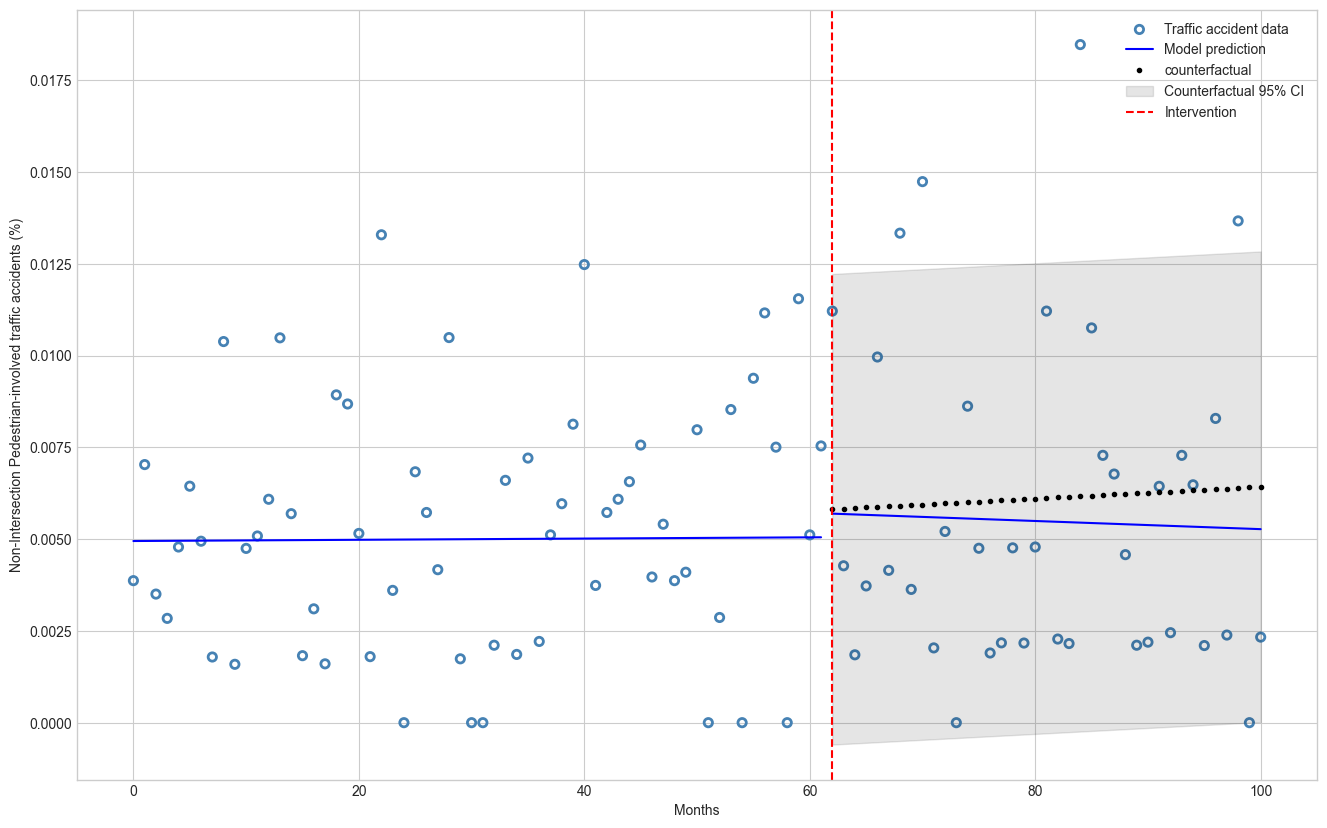

In [63]:
print(test_stationarity(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes']))

plot_acf(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'])
plt.show()

auto_model_full = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'], 
                      X=vb_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

print(auto_model_full.summary())

# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()
start = 62
end = len(vb_incidents_per_month)

arima_results = ARIMA(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'], vb_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'][:start], exogenous=vb_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=20, max_q=20, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(vb_incidents_per_month['percentage_pedestrian_nonintersection_crashes'][:start], vb_incidents_per_month["T"][:start], order=auto_model_cf.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=vb_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(vb_incidents_per_month["T"], vb_incidents_per_month["percentage_pedestrian_nonintersection_crashes"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(vb_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(vb_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=vb_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Non-Intersection Pedestrian-involved traffic accidents (%)")
plt.show()

### All Pedestrian-Vehicle Crashes

ADF Statistic: -10.985010
p-value: 0.000000
Critical Values:
	1%: -3.498
	5%: -2.891
	10%: -2.582
Series is stationary
None


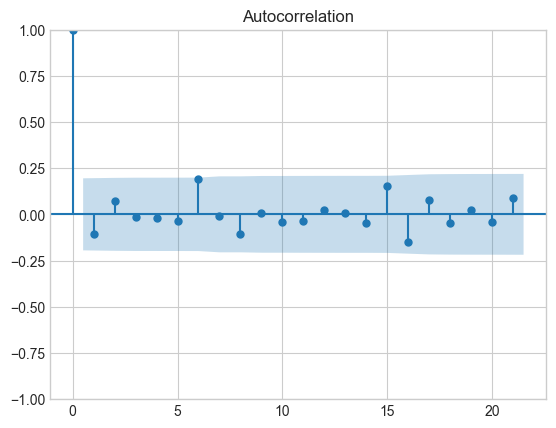

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-693.915, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-709.822, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-698.626, Time=0.07 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-724.514, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-727.527, Time=0.06 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-727.258, Time=0.02 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-725.749, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-733.300, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-736.541, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-730.254, Time=0.03 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-706.218, Time=0.05 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=144.717, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-744.851, Time=0.04 sec


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-706.632, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-734.156, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-740.816, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-743.396, Time=0.07 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-750.376, Time=0.04 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.974 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  101
Model:                        SARIMAX   Log Likelihood                 380.188
Date:                Thu, 01 Aug 2024   AIC                           -750.376
Time:                        16:26:54   BIC                           -737.300
Sample:                             0   HQIC                          -745.083
                                - 101                                         
Covariance Type:                  opg   

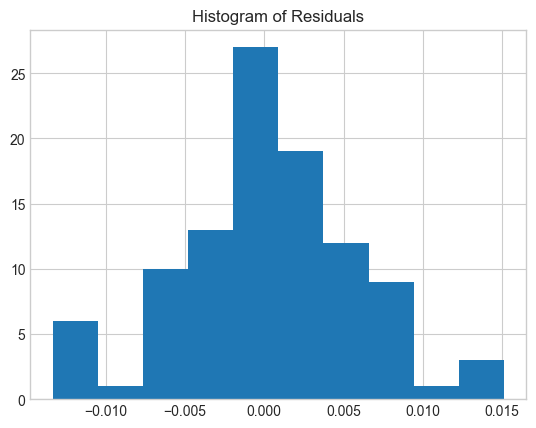

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-354.202, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-433.954, Time=0.02 sec


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-388.577, Time=0.03 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-446.646, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-451.035, Time=0.02 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=-450.091, Time=0.01 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-448.996, Time=0.04 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-453.994, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-467.057, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-444.597, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-401.845, Time=0.02 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-472.151, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-474.134, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-476.118, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-474.156, Time=0.01 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.400 seconds


/Users/ebrown/Documents/GitHub/Complaints_Analysis/.conda/lib/python3.8/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/var/folders/pl/smldwrws5sv13t7rs8_2y98htg6kdq/T/ipykernel_47426/1065306845.py:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


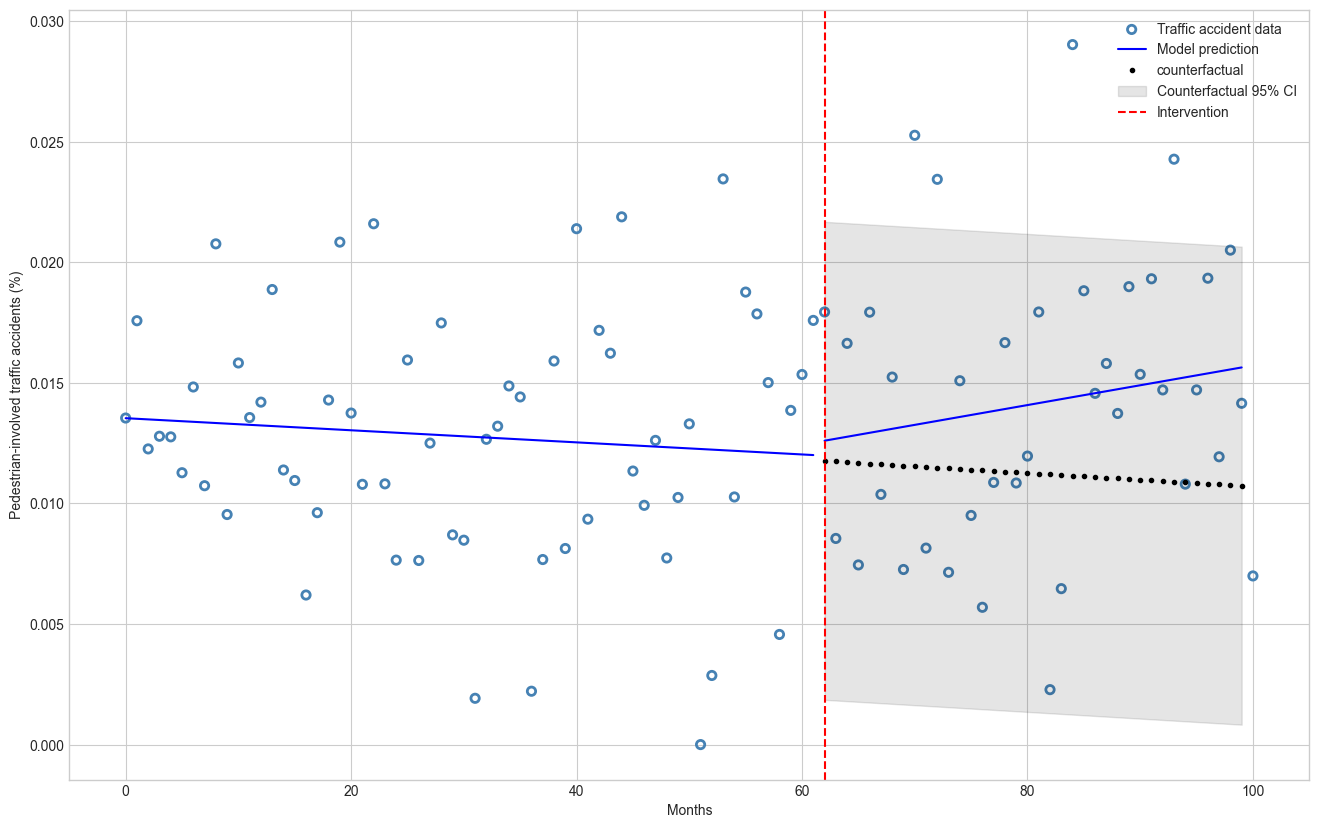

In [45]:
print(test_stationarity(vb_incidents_per_month['percentage_pedestrian_crashes']))

plot_acf(vb_incidents_per_month['percentage_pedestrian_crashes'])
plt.show()

auto_model_full = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_crashes'], 
                      X=vb_incidents_per_month[['T','D','P']],
                      start_p=0, start_q=0,
                      test='adf',       # Use ADF test to find optimal 'd'
                      max_p=20, max_q=20, # Maximum p and q
                      m=1,              # Frequency of the series
                      d=None,           # Let the model determine 'd'
                      seasonal=False,   # No seasonality
                      trace=True,       # Print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)    # Stepwise selection to find the best model

print(auto_model_full.summary())

# Check residuals
residuals = auto_model_full.resid()
plt.figure()
plt.hist(residuals)
plt.title('Histogram of Residuals')
plt.show()
start = 62
end = len(vb_incidents_per_month)

arima_results = ARIMA(vb_incidents_per_month['percentage_pedestrian_crashes'], vb_incidents_per_month[['T','D','P']], order=auto_model_full.order).fit()

predictions = arima_results.get_prediction(0, end-1)

# Use auto_arima to find the best ARIMA model parameters before the intervention
auto_model_cf = pm.auto_arima(vb_incidents_per_month['percentage_pedestrian_crashes'][:start], exogenous=vb_incidents_per_month[["T"][:start]],
                        start_p=0, start_q=0,
                        test='adf',       # Using ADF test to find optimal 'd'
                        max_p=20, max_q=20, # Search max bounds for p and q
                        m=1,              # Non-seasonal data
                        d=None,           # Let auto_arima determine 'd'
                        seasonal=False,   # No seasonality
                        stepwise=True,    # Use the stepwise algorithm
                        trace=True,       # Print status on the fits
                        error_action='ignore',  
                        suppress_warnings=True)

arima_cf = ARIMA(vb_incidents_per_month['percentage_pedestrian_crashes'][:start], vb_incidents_per_month["T"][:start], order=auto_model_cf.order).fit()

# Model predictions means
y_pred = predictions.predicted_mean

# Counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(steps=end-start, exog=vb_incidents_per_month["T"][start:end]).summary_frame(alpha=0.05)

# Plot section
plt.style.use('seaborn-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# Plot bounce rate data
ax.scatter(vb_incidents_per_month["T"], vb_incidents_per_month["percentage_pedestrian_crashes"], facecolors='none', edgecolors='steelblue', label="Traffic accident data", linewidths=2)

# Plot model predictions
# ax.plot(incidents_per_month["T"][:end], y_pred, 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][:start], y_pred[:start], 'b-', label="Model prediction")
ax.plot(vb_incidents_per_month["T"][start:end], y_pred[start:], 'b-')

# Plot counterfactual predictions with 95% confidence interval
ax.plot(vb_incidents_per_month["T"][start:end], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(vb_incidents_per_month["T"][start:end], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="Counterfactual 95% CI")

# Intervention line
ax.axvline(x=vb_incidents_per_month["T"][start], color='r', linestyle='--', label='Intervention')

# Labels and legends
ax.legend(loc='best')
plt.xlabel("Months")
plt.ylabel("Pedestrian-involved traffic accidents (%)")
plt.show()